In [1]:
import torch
from torch import tensor

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import Resize, ToTensor, Compose, Normalize
import numpy as np

### Логистическая регрессия на MNIST

В этом задании мы напишем свой классификатор картинок - с помощью одной лишь логистической регрессии.
Мы возьмем известный датасет MNIST - набор из 60 000 картинок рукописных цифр от 0 до 9. Задача модели  - получая на вход серую картинку размером 28*28 пикселей с нарисованой на ней цифрой - определить что это за цифра.


Мы накладываем серию транфсормаций для каждой картинки - сначала переводим их в тензор, а затем делаем нормализацию значений пикселей.
Сейчас они (пиксели) находятся в интервале от 0 до 255 - мы сократим это расстояние, и установить среднее значение как 0, а стандартное отклонение - 1.

В tochvision есть специальный модуль transfroms в котором уже реализовано большинство трасформаций.

In [4]:
transform = Compose([
        ToTensor(),
        Normalize(mean=[0.0], std=[1.0])]) 

MNIST является стандартным датасетом и поэтому мы легко импортируем его из библиотеки torchvision.
Он находиться в специальном понятном для Pytorch формате Dataset.

In [5]:
from torch.utils.data import DataLoader

data_train = MNIST('./', download=True, train=True, transform=transform)
data_test = MNIST('./', download=True, train=False, transform=transform)

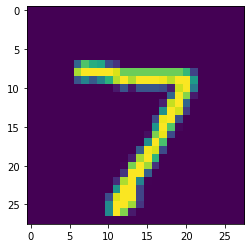

In [6]:
plt.imshow(data_test.data[0])

*Logistic Regression* - это все та же линейная регрессия + функция активации 

В случае бинарной классификации (когда модель учится только на двух категориях) - эта функция - Sigmoid или [логистическая функция](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D1%83%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5)

Если у нас классов больше чем два - вместо сигмоиды мы можем использовать функцию [SoftMax](https://ru.wikipedia.org/wiki/Softmax).
Это версия той же логистической функции, но только для многомерного случая.

Она нормализирует выходные значения сети, чтобы те были в интервале от 0 до 1 и их сумма была равна 1.
В таком виде выходные значения можно интерпретировать как "вероятности" - на сколько вероятно модель считает верным тот или иной класс.




In [371]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum(axis)

### Задание 1:
Напишите функцию логистической регресии.

In [373]:
def logistic_regression(x, W):
    
    z = x@W
#    y = softmax(z)
    y = torch.softmax(z, 1)

    return y

Выходные значения нашей модели будут выглядеть как вектор вероятностей:

[0.8, 0.2, ... , 0.001] - где индекс вероятности в векторе соответствует номеру класса.
Например, в векторе выше 0.8 это вероятность того что число на картинке - 0, 0.2 - что 1 и так далее.

#### Задание 1.2 Прочитать более детально про кросс-ентропию
https://gombru.github.io/2018/05/23/cross_entropy_loss/

https://peterroelants.github.io/posts/cross-entropy-softmax/



## Напишите код для мультиклассовой кросс-энтропиии

Здесь вы найдете правильную реализацию, если запутаетесь
https://gist.github.com/ArtemCLime/18ebb1adafe95631e9f2ff9cf8b2df99

НО постарайтесь НЕ ИСПОЛЬЗОВАТЬ ее, а попробовать написать функцию самостоятельно, используя источники выше

In [374]:
# Кросс-энтропия для мультиклассового случая

def cross_entropy_loss(y_hat, y_true):
    # Выбираем вероятности для правильных классов
    logits_for_answers = y_hat[np.arange(len(y_hat)),  y_true]
    
    # Считаем кросс-ентропию для каждого из классов
    xentropy = -torch.log(logits_for_answers)
    return xentropy.sum() / len(y_true)

### Для проверки используйте этот кусок кода - числа у вашей кросс-ентропии и pytorch-реализации должны совпасть

In [375]:
y_hat = tensor([[0.1, 0.1, 0.8], [0.1, 0.5, 0.4], [0.3, 0.3, 0.4]])
y_true = tensor([0, 1, 0])

cross_entropy_loss(torch.softmax(y_hat, -1), y_true), torch.nn.functional.cross_entropy(y_hat, y_true)

(tensor(1.1562), tensor(1.1562))

### Задание 2:
Напишите функцию для градиентного спуска

In [376]:
def gradient_descent(W, learning_rate):
    # Your code here
    with torch.no_grad():
      W.sub_(learning_rate * W.grad)  # Weights update
      W.grad.zero_() # Zero gradient
    
    return W

### Задание 3:
Напишите функцию для подсчета точности

Hint: Функция argmax 

In [377]:
def score(y_hat, y_true):
    # Your code here
#    accuracy = torch.argmax(y_hat).float().mean()
    y_hat = torch.argmax(y_hat, dim=1)
    return (y_hat == y_true).float().mean()

In [378]:
# Мы "растягиваем" нашу картинку 28*28 в один длинный вектор размером 784, для нашей логистической регресии
# Задание 3.5 - почитайте про .view метод в PyTorch и разберитесь как он действует

def preprocess_data(x):
    return x.view(-1, 28*28)

### Задание 4:
Заполните сколько у нас фичей для каждой картинки и сколько классов

In [379]:
NUM_FEATURES = 784
NUM_CLASSES = 10


W = torch.nn.Parameter(torch.ones(NUM_FEATURES, NUM_CLASSES))

### Задание 5:
Напишите функцию для обучения модели

In [380]:
def train_epoch(train_data, W, learning_rate):
    
    losses = []
    scores = []
    
    for x, y in train_data:
        x = preprocess_data(x)
        
        y_hat = logistic_regression(x, W)

        loss = cross_entropy_loss(y_hat, y)
        
        loss.backward()
        
        W = gradient_descent(W, learning_rate)
       
        losses.append(loss.item())
        scores.append(score(y_hat, y))
    return W, np.mean(losses), np.mean(scores)

### Задание 6:
Напишите функцию для тестирования модели
Hint (во время тестиования мы не обновляем веса)

In [381]:
def test_epoch(test_data, W):
    losses = []
    scores = []
    
    for x, y in test_data:
        x = preprocess_data(x)
           
        y_hat = logistic_regression(x, W)

        loss = cross_entropy_loss(y_hat, y)

        losses.append(loss.item())
        scores.append(score(y_hat, y))
    return np.mean(losses), np.mean(scores)

Мы используем класс DataLoader от Pytorch - он позволяет нам удобно и быстро читать датасет батчами
Учитывая простоту модели мы можем брать батчи по-больше - даже на СРU это не займет много времени

In [382]:
train = DataLoader(data_train, batch_size=256)
test = DataLoader(data_test, batch_size=512)

### Задание 7:
Подберите гиперпараметры - количество епох и learning rate для наилучших результатов.
На данном датасете вы можете набрать более 0.9 точности даже с такой простой моделью.

In [383]:
W = torch.nn.Parameter(torch.ones(NUM_FEATURES, NUM_CLASSES))

EPOCHS = 5

learning_rate = 0.5

for i in range(EPOCHS):
    W, train_loss, train_accuracy = train_epoch(train, W, learning_rate)
    
    test_loss, test_accuracy = test_epoch(test, W)

    print (f'Epoch #{i}')
    print (f'Train Accuracy: {train_accuracy}, train loss: {train_loss}')
    print (f'Test Accuracy: {test_accuracy}, test loss: {test_loss}')
    print ("#"*10)

Epoch #0
Train Accuracy: 0.8736259341239929, train loss: 0.46342650379272216
Test Accuracy: 0.9013557434082031, test loss: 0.34756793081760406
##########
Epoch #1
Train Accuracy: 0.9050753712654114, train loss: 0.33659019077077823
Test Accuracy: 0.9095473289489746, test loss: 0.3197407938539982
##########
Epoch #2
Train Accuracy: 0.9109929800033569, train loss: 0.31682583683348714
Test Accuracy: 0.9116727709770203, test loss: 0.3090470261871815
##########
Epoch #3
Train Accuracy: 0.9144670367240906, train loss: 0.30638821562553975
Test Accuracy: 0.9140912294387817, test loss: 0.3032784044742584
##########
Epoch #4
Train Accuracy: 0.9172872304916382, train loss: 0.29953929258787887
Test Accuracy: 0.9150563478469849, test loss: 0.29961206689476966
##########


In [384]:
if (test_accuracy) > 0.9:
    print ("Поздравляю, все получилось!")
else:
    print ("Стоит еще попробовать!")

Поздравляю, все получилось!
